# Twitter Sentiment Analysis Using RNN

In [1]:
!nvidia-smi

Mon Nov 21 17:06:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:4B:00.0 Off |                    0 |
|  0%   59C    P0    92W / 300W |      4MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import string
from collections import Counter
from string import punctuation

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Use GPU if available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda:0


## IMDB Movies Review Dataset

In [3]:
# !wget -O training.1600000.processed.noemoticon.csv https://utdallas.app.box.com/shared/static/kw4a5e3lk00731kyho8kd2c6hwlr0t2m/
# !curl -L "https://utdallas.app.box.com/shared/static/kw4a5e3lk00731kyho8kd2c6hwlr0t2m/" --output training.1600000.processed.noemoticon.csv

--2022-11-21 17:06:33--  https://utdallas.app.box.com/shared/static/kw4a5e3lk00731kyho8kd2c6hwlr0t2m/
Resolving utdallas.app.box.com (utdallas.app.box.com)... 74.112.186.144
Connecting to utdallas.app.box.com (utdallas.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/kw4a5e3lk00731kyho8kd2c6hwlr0t2m [following]
--2022-11-21 17:06:33--  https://utdallas.app.box.com/public/static/kw4a5e3lk00731kyho8kd2c6hwlr0t2m
Reusing existing connection to utdallas.app.box.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://dl2.boxcloud.com/d/1/b1!YQgULKDM8oWKm58BK2YhkMIxaRccIY8LhufI_t57opZ3iV3uk5Fo3TdkNOwomjZium_KTvKbRn_iLLNt1lM4qVmyS-PqBfq7MGoV4W_vCkkDFqJvVO-nZ3O5agsEIlEyur_CP7bgBcYlkhhBmpxntLeJPJmXzZIbGbhrWqxTi59515k0tfePbBD3fLytm1CegAKYsPFSid7toosS2i9mvTDdCiwPD4gYLF_BCbBJS6b1tmSjYarPOVgxgp33_ilKNoZ7v5FFvYEP6Rnb8MXQKMa57m0oRYxoXk5ysOqA0FFcuaj-AAwVKy-UhWgtiXZ8rK0FxvIMgD3QB3J_aSTMOVg1Vt-wVoW7

In [4]:
m_cols = ["target", "ids", "date", "flag", "user", "text"]
df_data = pd.read_csv("./training.1600000.processed.noemoticon.csv", names=m_cols, encoding='latin-1')
limited_data = False
if limited_data:
    count = 100000
    neg_idx = 0
    pos_idx = 800001
    df = pd.concat([df_data[neg_idx:neg_idx + count], df_data[pos_idx:pos_idx + count]])
else:
    df = df_data
data = df[["target", "text"]]
data = data[data["target"] != 2]
tweets = data["text"].tolist()
labels = data["target"].tolist()

In [5]:
tweets = [str(tweet).lower().translate(str.maketrans('', '', string.punctuation)) for tweet in tweets]

In [6]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [7]:
all_tweets = ' '.join(tweets)
# create a list of words
words = all_tweets.split()
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)
print(count_words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
print(count_words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
UNK = 1
vocab_to_int = {w: i + 2 for i, (w, c) in enumerate(sorted_words)}

In [10]:
print (vocab_to_int)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
tweets_int = []
for tweet in tweets:
    r = [vocab_to_int[w] if w in vocab_to_int else 1 for w in tweet.split()]
    tweets_int.append(r)
print(tweets_int[0:3])
encoded_labels = [1 if label == 4 else 0 for label in labels]

[[20177, 254587, 462, 103, 5, 1217, 8, 3540, 49, 874, 10240, 13, 1883, 32, 3, 41, 10, 447], [9, 781, 19, 108, 48, 543, 180, 547, 121, 2048, 10, 7, 285, 527, 78, 5, 2336, 146, 43, 262, 1198], [28049, 2, 110469, 310, 349, 11, 4, 1353, 1650, 3, 903, 1345, 4, 469, 39, 35, 13, 25889]]


In [12]:
encoded_labels = [1 if label == 4 else 0 for label in labels]

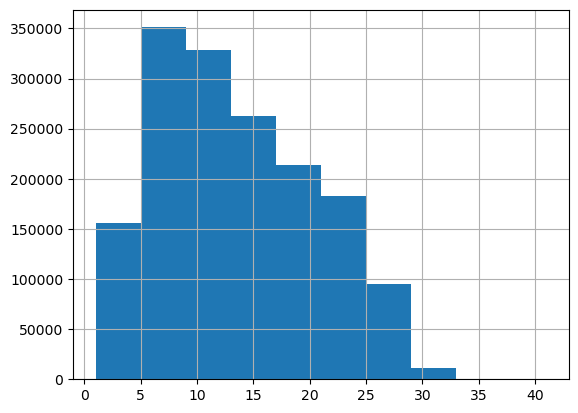

count    1.600000e+06
mean     1.303716e+01
std      6.902189e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.800000e+01
max      4.100000e+01
dtype: float64

In [13]:
# %matplotlib inline
tweets_len = [len(x) for x in tweets_int]
pd.Series(tweets_len).hist()
plt.show()
pd.Series(tweets_len).describe()

In [14]:
tweets_int = [tweets_int[i] for i, l in enumerate(tweets_len) if l > 0]
encoded_labels = [encoded_labels[i] for i, l in enumerate(tweets_len) if l > 0]
encoded_labels = np.array(encoded_labels)
print(encoded_labels)

[0 0 0 ... 1 1 1]


In [15]:
def pad_features(tweets_int, seq_length):
    """
    Return features of review_ints, where each tweet is padded with 0's or
    truncated to the input seq_length.
    """
    features = np.zeros((len(tweets_int), seq_length), dtype=int)
    new = []
    for i, tweet in enumerate(tweets_int):
        tweet_len = len(tweet)

        if tweet_len <= seq_length:
            zeroes = list(np.zeros(seq_length - tweet_len))
            new = zeroes + tweet
        elif tweet_len > seq_length:
            new = tweet[0:seq_length]

        features[i, :] = np.array(new)

    return features

In [16]:
#batch_size = 50
batch_size = 6000
seq_length = 200
drop_last = True

In [17]:
features = pad_features(tweets_int, seq_length)
len_feat = len(features)
print(features[:10, :])

[[     0      0      0 ...     41     10    447]
 [     0      0      0 ...     43    262   1198]
 [     0      0      0 ...     35     13  25889]
 ...
 [     0      0      0 ...     76    798      8]
 [     0      0      0 ...    114     18     10]
 [     0      0      0 ...   2504     16 254589]]


In [18]:
split_frac = 0.8
train_x = features[0:int(split_frac * len_feat)]
train_y = encoded_labels[0:int(split_frac * len_feat)]
remaining_x = features[int(split_frac * len_feat):]
remaining_y = encoded_labels[int(split_frac * len_feat):]
valid_x = remaining_x[0:int(len(remaining_x) * 0.5)]
valid_y = remaining_y[0:int(len(remaining_y) * 0.5)]
test_x = remaining_x[int(len(remaining_x) * 0.5):]
test_y = remaining_y[int(len(remaining_y) * 0.5):]

In [19]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

In [20]:
# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=drop_last)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=drop_last)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=drop_last)

In [21]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample input size: ', sample_x.size())  # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size())  # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([5000, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,    16,   120,   106],
        [    0,     0,     0,  ...,   128,     5,   325],
        [    0,     0,     0,  ...,     3,  3452,    43],
        ...,
        [    0,     0,     0,  ...,     5,    30,    32],
        [    0,     0,     0,  ...,   713,    10, 14258],
        [    0,     0,     0,  ...,    16,    38,    83]])

Sample label size:  torch.Size([5000])
Sample label: 
 tensor([0, 0, 0,  ..., 1, 1, 0])


# LSTM

In [22]:
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim1,
                 hidden_dim2, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim1, n_layers,
                            dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # FC linear and ReLU layers
        self.fc1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()

        # linear and sigmoid layers
        self.fc2 = nn.Linear(hidden_dim2, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim1)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc1(out)

        # relu activation
        out = self.relu(out)

        out = self.fc2(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        """ Initializes hidden state """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim1).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim1).zero_().to(device))
        return hidden

In [23]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 2  # +2 for the 0 padding, 1 UNKNOWN
embedding_dim = 400
hidden_dim1 = 256
hidden_dim2 = 128
output_size = 1
n_layers = 2

# training params
lr = 0.001
epochs = 4  # 3-4 is approx where I noticed the validation loss stop decreasing
counter = 0
print_every = 100
clip = 5  # gradient clipping

model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim1, hidden_dim2, n_layers)
print(model)

# loss and optimization functions
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(850173, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [24]:
# move model to GPU, if available
model = model.to(device)

valid_loss_min = np.Inf

model.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = model.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        model.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inputs, labels in valid_loader:
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                inputs = inputs.type(torch.LongTensor)
                inputs, labels = inputs.to(device), labels.to(device)
                output, val_h = model(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            model.train()
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './lstm_state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 1/4... Step: 100... Loss: 0.436668... Val Loss: 0.691436
Validation loss decreased (inf --> 0.691436).  Saving model ...
Epoch: 1/4... Step: 200... Loss: 0.397160... Val Loss: 0.645828
Validation loss decreased (0.691436 --> 0.645828).  Saving model ...
Epoch: 2/4... Step: 300... Loss: 0.376070... Val Loss: 0.593196
Validation loss decreased (0.645828 --> 0.593196).  Saving model ...
Epoch: 2/4... Step: 400... Loss: 0.363025... Val Loss: 0.555839
Validation loss decreased (0.593196 --> 0.555839).  Saving model ...
Epoch: 2/4... Step: 500... Loss: 0.348109... Val Loss: 0.563711
Epoch: 3/4... Step: 600... Loss: 0.329400... Val Loss: 0.563726
Epoch: 3/4... Step: 700... Loss: 0.325752... Val Loss: 0.508574
Validation loss decreased (0.555839 --> 0.508574).  Saving model ...
Epoch: 4/4... Step: 800... Loss: 0.288925... Val Loss: 0.688716
Epoch: 4/4... Step: 900... Loss: 0.271377... Val Loss: 0.685350
Epoch: 4/4... Step: 1000... Loss: 0.288123... Val Loss: 0.630765


In [25]:
def print_data_accuracy(model, data_loader, data_type='Test'):
    # Get test data loss and accuracy
    data_losses = []  # track loss
    num_correct = 0

    # init hidden state
    h = model.init_hidden(batch_size)

    model.eval()
    # iterate over test data
    for inputs, labels in data_loader:
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # get predicted outputs
        inputs = inputs.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs, h)

        # calculate loss
        data_loss = criterion(output.squeeze(), labels.float())
        data_losses.append(data_loss.item())

        # convert output probabilities to predicted class (0 or 1)
        pred = torch.round(output.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.detach().cpu().numpy())
        num_correct += np.sum(correct)

    # -- stats! -- ##
    # avg data loss
    print(f"{data_type} loss: {np.mean(data_losses):.3f}")

    # accuracy over all the data
    data_acc = num_correct / len(data_loader.dataset)
    print(f"{data_type} accuracy: {data_acc:.3f}")
    print()

In [26]:
# Loading the best model
model.load_state_dict(torch.load('./lstm_state_dict.pt'))

<All keys matched successfully>

In [27]:
print(f"\nLSTM - Twitter 1,600,000 Data Accuracies: ")
print_data_accuracy(model, train_loader, data_type="Train")
print_data_accuracy(model, valid_loader, data_type="Valid")
print_data_accuracy(model, test_loader, data_type="Test")


LSTM - Twitter 1,600,000 Data Accuracies: 
Train loss: 0.288
Train accuracy: 0.880

Valid loss: 0.509
Valid accuracy: 0.763

Test loss: 0.537
Test accuracy: 0.752



# GRU

In [28]:
class SentimentGRU(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim1,
                 hidden_dim2, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2

        # embedding and GRU layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim1, n_layers,
                            dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # FC linear and ReLU layers
        self.fc1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()

        # linear and sigmoid layers
        self.fc2 = nn.Linear(hidden_dim2, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and gru_out
        embeds = self.embedding(x)
        gru_out, hidden = self.gru(embeds, hidden)

        # stack up gru outputs
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim1)

        # dropout and fully-connected layer
        out = self.dropout(gru_out)
        out = self.fc1(out)

        # relu activation
        out = self.relu(out)

        out = self.fc2(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        """ Initializes hidden state """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of GRU
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim1).zero_().to(device)
        return hidden

In [29]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 2  # +2 for the 0 padding, 1 UNKNOWN
embedding_dim = 400
hidden_dim1 = 256
hidden_dim2 = 128
output_size = 1
n_layers = 2

# training params
lr = 0.001
epochs = 4  # 3-4 is approx where I noticed the validation loss stop decreasing
counter = 0
print_every = 100
clip = 5  # gradient clipping

model = SentimentGRU(vocab_size, output_size, embedding_dim, hidden_dim1, hidden_dim2, n_layers)
print(model)

# loss and optimization functions
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

SentimentGRU(
  (embedding): Embedding(850173, 400)
  (gru): GRU(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [30]:
# move model to GPU, if available
model = model.to(device)

valid_loss_min = np.Inf

model.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = model.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        # h = tuple([each.data for each in h])
        h = h.data

        inputs = inputs.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero accumulated gradients
        model.zero_grad()

        # get the output from the model
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inputs, labels in valid_loader:
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = val_h.data

                inputs = inputs.type(torch.LongTensor)
                inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = model(inputs, val_h)

                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())

            model.train()
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './gru_state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 1/4... Step: 100... Loss: 0.441532... Val Loss: 0.711466
Validation loss decreased (inf --> 0.711466).  Saving model ...
Epoch: 1/4... Step: 200... Loss: 0.406568... Val Loss: 0.616920
Validation loss decreased (0.711466 --> 0.616920).  Saving model ...
Epoch: 2/4... Step: 300... Loss: 0.367989... Val Loss: 0.522253
Validation loss decreased (0.616920 --> 0.522253).  Saving model ...
Epoch: 2/4... Step: 400... Loss: 0.359478... Val Loss: 0.563472
Epoch: 2/4... Step: 500... Loss: 0.367941... Val Loss: 0.580040
Epoch: 3/4... Step: 600... Loss: 0.325200... Val Loss: 0.592292
Epoch: 3/4... Step: 700... Loss: 0.351810... Val Loss: 0.595815
Epoch: 4/4... Step: 800... Loss: 0.276123... Val Loss: 0.597794
Epoch: 4/4... Step: 900... Loss: 0.278023... Val Loss: 0.679470
Epoch: 4/4... Step: 1000... Loss: 0.280708... Val Loss: 0.603732


In [31]:
# Loading the best model GRU
model.load_state_dict(torch.load('./gru_state_dict.pt'))

<All keys matched successfully>

In [32]:
def print_data_accuracy(model, data_loader, data_type='Test'):
    # Get test data loss and accuracy
    data_losses = []  # track loss
    num_correct = 0

    # init hidden state
    h = model.init_hidden(batch_size)

    model.eval()
    # iterate over test data
    for inputs, labels in data_loader:
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = h.data

        # get predicted outputs
        inputs = inputs.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs, h)

        # calculate loss
        data_loss = criterion(output.squeeze(), labels.float())
        data_losses.append(data_loss.item())

        # convert output probabilities to predicted class (0 or 1)
        pred = torch.round(output.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.detach().cpu().numpy())
        num_correct += np.sum(correct)

    # -- stats! -- ##
    # avg data loss
    print(f"{data_type} loss: {np.mean(data_losses):.3f}")

    # accuracy over all the data
    data_acc = num_correct / len(data_loader.dataset)
    print(f"{data_type} accuracy: {data_acc:.3f}")
    print()

In [33]:
print(f"\nGRU - Twitter 1,600,000 Data Accuracies: ")
print_data_accuracy(model, train_loader, data_type="Train")
print_data_accuracy(model, valid_loader, data_type="Valid")
print_data_accuracy(model, test_loader, data_type="Test")


GRU - Twitter 1,600,000 Data Accuracies: 
Train loss: 0.367
Train accuracy: 0.838

Valid loss: 0.522
Valid accuracy: 0.737

Test loss: 0.539
Test accuracy: 0.727



## Sample Test Tokenizer and Features

In [34]:
def tokenize_review(test_review):
    test_review = test_review.lower()  # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] if word in vocab_to_int else 1 for word in test_words])

    return test_ints


def predict(net, test_review, sequence_length=200):
    net.eval()

    # tokenize review
    test_ints = tokenize_review(test_review)

    # pad tokenized sequence
    seq_length = sequence_length
    features = pad_features(test_ints, seq_length)

    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)

    batch_size = feature_tensor.size(0)

    # initialize hidden state
    h = net.init_hidden(batch_size)

    feature_tensor = feature_tensor.to(device)

    # get the output from the model
    output, h = net(feature_tensor, h)

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))

    # print custom response
    if pred.item() == 1:
        print("Positive review detected!")
    else:
        print("Negative review detected.")


test_review = 'This movie had the best acting and the dialogue was so good. I loved it.'
seq_length = 200  # good to use the length that was trained on
predict(model, test_review, seq_length)

# test code and generate tokenized review
test_ints = tokenize_review(test_review)
print(test_ints)

# test sequence padding
seq_length = 200
features = pad_features(test_ints, seq_length)

print(features)

# test conversion to tensor and pass into your model
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())

Prediction value, pre-rounding: 0.982435
Positive review detected!
[[28, 218, 63, 4, 169, 1881, 7, 4, 12507, 27, 17, 30, 2, 522, 10]]
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0   